In [1]:
%reload_ext autoreload
%autoreload 2
%matplotlib inline
from fastai.vision import *
from fastai.metrics import error_rate
from pathlib import Path

doc(ImageDataBunch)


class ImageDataBunch [source] [test] ImageDataBunch ( train_dl : DataLoader , valid_dl : DataLoader , fix_dl : DataLoader = None , test_dl : Optional [ DataLoader ]= None , device : device = None , dl_tfms : Optional [ Collection [ Callable ]]= None , path : PathOrStr = '.' , collate_fn : Callable = 'data_collate' , no_check : bool = False ) :: DataBunch 
 
 × No tests found for ImageDataBunch . To contribute a test please refer to this guide and this discussion . DataBunch suitable for computer vision. 
 Show in docs

In [2]:
doc(ImageDataBunch.from_folder)

from_folder [source] [test] from_folder ( path : PathOrStr , train : PathOrStr = 'train' , valid : PathOrStr = 'valid' , test : Union [ Path , str , NoneType ]= None , valid_pct = None , seed : int = None , classes : Collection [ T_co ]= None , ** kwargs : Any ) → ImageDataBunch 
 
 × Tests found for from_folder : pytest -sv tests/test_vision_data.py::test_from_folder [source] To run tests please refer to this guide . Create from imagenet style dataset in path with train , valid , test subfolders (or provide valid_pct ). 
 Show in docs

In [3]:
path = Path('/home/jupyter/projects/project-1/training-data/images'); path

PosixPath('/home/jupyter/projects/project-1/training-data/images')

In [4]:
def toPathsAndLabels(path, trainFile):
    paths = []
    labels = []
    for name in trainFile:
        name = name.rstrip()
        name+='.jpg'
        paths.append(path/name)
        labels.append(re.search('^(.+)/([^/]+)$', name).group(1).replace('_', ' '))
    return paths, labels
trainFile = open("./project-1/training-data/train.txt", "r")
fn_paths, fn_labels = toPathsAndLabels(path, trainFile); fn_paths[:2]; fn_labels[:2]

['apple pie', 'apple pie']

In [22]:
with open('paths_and_labels.txt', 'w') as f:
    for path, label in zip(fn_paths, fn_labels):
        f.write("Path: %s ... Label: %s\n" % (path, label))

In [5]:
data = ImageDataBunch.from_lists(path, fn_paths, labels=fn_labels, ds_tfms=get_transforms(), size=224).normalize(imagenet_stats)

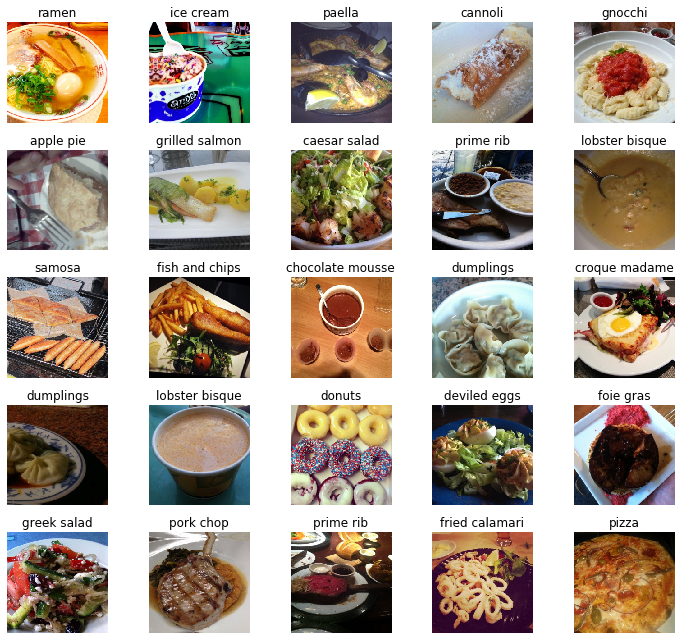

In [21]:
data.show_batch(rows=5, figsize=(10,9))

In [20]:
doc(data.show_batch)

show_batch [source] [test] show_batch ( rows : int = 5 , ds_type : DatasetType = <DatasetType.Train: 1> , reverse : bool = False , ** kwargs ) 
 
 × Tests found for show_batch : pytest -sv tests/test_basic_data.py::test_DataBunch_show_batch [source] To run tests please refer to this guide . Show a batch of data in ds_type on a few rows . 
 Show in docs

In [8]:
len(data.classes),data.c

(101, 101)

In [9]:
learn = cnn_learner(data, models.resnet34, metrics=error_rate)

In [10]:
learn.model

Sequential(
  (0): Sequential(
    (0): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
    (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU(inplace=True)
    (3): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
    (4): Sequential(
      (0): BasicBlock(
        (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (relu): ReLU(inplace=True)
        (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      )
      (1): BasicBlock(
        (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  

In [11]:
learn.fit_one_cycle(4)

epoch,train_loss,valid_loss,error_rate,time
0,2.361038,1.861044,0.473993,07:32
1,1.939949,1.525811,0.391155,06:14
2,1.658692,1.378735,0.357888,06:17
3,1.547365,1.340609,0.349703,06:18


In [12]:
interp = ClassificationInterpretation.from_learner(learn)

losses,idxs = interp.top_losses()

len(data.valid_ds)==len(losses)==len(idxs)

True

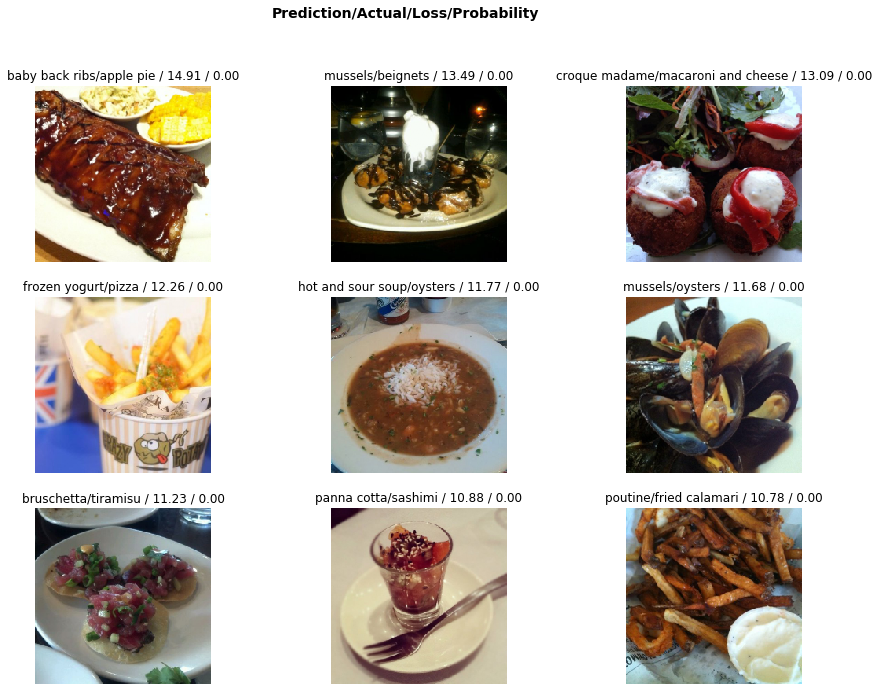

In [13]:
interp.plot_top_losses(9, figsize=(15,11))

In [23]:
interp.most_confused(min_val=2)

[('beef tartare', 'tuna tartare', 21),
 ('steak', 'filet mignon', 21),
 ('chocolate mousse', 'chocolate cake', 19),
 ('filet mignon', 'steak', 18),
 ('steak', 'prime rib', 18),
 ('apple pie', 'bread pudding', 14),
 ('pork chop', 'steak', 14),
 ('prime rib', 'steak', 14),
 ('pulled pork sandwich', 'hamburger', 14),
 ('shrimp and grits', 'gnocchi', 14),
 ('steak', 'baby back ribs', 14),
 ('steak', 'pork chop', 14),
 ('donuts', 'beignets', 13),
 ('dumplings', 'gyoza', 13),
 ('panna cotta', 'cheesecake', 13),
 ('panna cotta', 'chocolate mousse', 13),
 ('chocolate mousse', 'panna cotta', 12),
 ('lobster bisque', 'clam chowder', 12),
 ('chocolate cake', 'red velvet cake', 11),
 ('hummus', 'chicken quesadilla', 11),
 ('miso soup', 'lobster bisque', 11),
 ('pork chop', 'grilled salmon', 11),
 ('ravioli', 'lasagna', 11),
 ('ravioli', 'shrimp and grits', 11),
 ('tiramisu', 'carrot cake', 11),
 ('chocolate cake', 'chocolate mousse', 10),
 ('greek salad', 'caprese salad', 10),
 ('huevos rancheros'

In [24]:
learn.save('stage-1')

In [25]:
learn.lr_find()

LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.


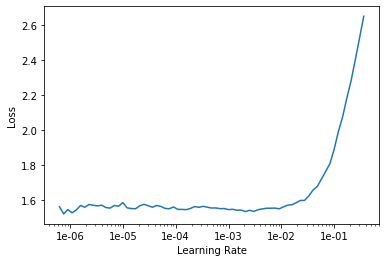

In [26]:
learn.recorder.plot()

In [27]:
learn.unfreeze()
learn.fit_one_cycle(2, max_lr=slice(1e-6,1e-2))

epoch,train_loss,valid_loss,error_rate,time
0,1.688618,1.344607,0.350363,07:14
1,1.128507,1.026019,0.271155,07:15
